In [1]:
import GA
import smc_abc
import smc_abc_ours
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pyabc
import time
import matplotlib.pyplot as plt
from scipy import optimize
import pickle

In [2]:
tag = 'Case2'

In [3]:
def compare_params_bar(true_params,popt, ga, smcabc_lit,smcabc_ours):
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*6
    
    
    plt.figure(figsize=(6,3))
    plt.bar(pos,[true_params[col] for col in cols],label='True',zorder=1)
    plt.bar(pos+1,popt,label='LSQ',zorder=1)
    
    ## GA
    plt.bar(pos+2,
            [np.median([item.genes[col] for item in ga.population]) for col in cols],
            label='GA',zorder=1)
    s = len(ga.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(2,0.05,size=s),
                    [item.genes[col] for item in ga.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
        
        
    ## SMC-ABC classic
    df,w = smcabc_lit.history.get_distribution()
    df = df.loc[:,cols]
    plt.bar(pos+3,[np.median(df[col]) for col in cols],label='Classic SMC-ABC',zorder=1)
    
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*df.shape[0]+np.random.normal(3,0.05,size=df.shape[0]),
                    df[col],color='gray',alpha=0.5,s=5,zorder=2)
        
    ## This work
    
    plt.bar(pos+4,[np.median([item[col] for item in smcabc_ours.population]) for col in cols],label='This work',zorder=1)
    
    s = len(smcabc_ours.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(4,0.05,size=s),
                    [item[col] for item in smcabc_ours.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
    
    
    plt.legend(bbox_to_anchor=(1.01,1))
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.xticks([2,8],['a1','a2'])
    plt.show()

In [4]:
def compare_params_hist(true_params,popt, ga, smcabc_lit,smcabc_ours,outname=None):
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*6
    df,w = smcabc_lit.history.get_distribution()
    
    plt.figure(figsize=(9,3))
    for i,col in enumerate(cols):
        plt.subplot(1,len(true_params),i+1)
        plt.plot([true_params[col]]*2,[0,25],label='True',color='k')
        #plt.hist(true_params[col],label='True',color='k')
        plt.plot([popt[i]]*2,[0,25],label='LSQ',color='r')
        
        #plt.hist(popt[i],label='LSQ',alpha=0.5)
        plt.hist([item.genes[col] for item in ga.population],label='GA',alpha=0.5)
        plt.hist(df[col],label='Classic SMC-ABC',alpha=0.5)
        plt.hist([item[col] for item in smcabc_ours.population],label='This work',alpha=0.5)
    
    labels = ['a','b','c']
    for i in range(len(cols)):
        plt.subplot(1,len(true_params),i+1)
        if i==2: plt.legend(bbox_to_anchor=(1.01,1))
        plt.xlabel(labels[i])
        plt.ylabel('Counts')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

### Case 1: y=2sinx1+3cosx2+ 1

In [5]:
def case():
    def model(param):
     # {'p0':,'p1':,...}
        
        res = param['p0']*np.sin(x_exp[:,0]) + param['p1']*np.sin(x_exp[:,1]) + param['p2']
        
        return {'data': res}
    
    def distance(x,y):
        return MSE(x['data'],y['data'])
    
    def residual_model(p):
        return y_exp['data']-model({'p{0}'.format(i):p[i] for i in range(len(p))})['data']

    param_num = 3
    population_size = 100
    training_samples =  100
    max_ite = 1000
    
    priors1 = pyabc.Distribution(**{'p{0}'.format(i):pyabc.RV('norm',5,3) for i in range(param_num)})
    priors2 = {'p{0}'.format(i):smc_abc_ours.RV('normal',5,3) for i in range(param_num)}
    
    np.random.seed(2)
    x_exp       = np.random.normal(size=(training_samples,param_num))
    true_params = {'p0':2,'p1':3,'p2':1}
    y_true       = model(true_params)
    y_exp = dict()
    y_exp['data']= y_true['data'] + np.random.normal(scale=2,size=training_samples)
    print('MSE best:', MSE(y_exp['data'],y_true['data']))
    min_dist = MSE(y_exp['data'],y_true['data'])
    
    np.random.seed()
    plt.scatter(y_true['data'],y_exp['data'])
    plt.xlabel('True')
    plt.ylabel('True+Noise')
    plt.show()
    
    popt, _= optimize.leastsq(residual_model, [5,5,5])
    print('Leastsq:',popt)
    print('Leastsq MSE:',distance(y_exp,model({'p{0}'.format(i):popt[i] for i in range(len(popt))})))
    
    
    ga = GA.GA(model,
         distance,
         y_exp,
         priors2,
         population_size=population_size, 
         mutation_rate=0.1,
         mutation_scale=0.1,
         max_ite=max_ite,
         min_dist=min_dist
         )
    t0 = time.time()
    ga.run()
    print('GA time:',time.time()-t0)
    
    GA.plot_training_curve(ga,'../figures/{0}_ga.pdf'.format(tag))
    GA.plot_params_bar(true_params,ga)
    
    
    
    smcabc_lit = smc_abc.smc_abc(model,
               distance,
               y_exp,
               priors1,
               population_size,
               min_dist=min_dist,
               max_ite=max_ite)
    t0 = time.time()
    smcabc_lit.run()
    print('SMC-ABC classical:',time.time()-t0)
    smc_abc.plot_params_bar(smcabc_lit,true_params)
    smc_abc.plot_training_curve(smcabc_lit,'../figures/{0}_smc_abc_classic.pdf'.format(tag))


    smcabc_ours = smc_abc_ours.smc_abc_ours(model,
                   priors2,
                   min_dist,
                   population_size,
                   distance_function=distance,
                   Yobs=y_exp,
                   max_iter=max_ite,
                   cores=4,
                   generation_size=population_size)
    
    t0=time.time()
    smcabc_ours.run_simulation()
    print('SMC-ABC this work:',time.time()-t0)
    
    smc_abc_ours.plot_params_bar(true_params,smcabc_ours)
    smc_abc_ours.plot_training_curve(smcabc_ours,'../figures/{0}_smc_abc_this_work.pdf'.format(tag))
    
    return true_params,popt, ga, smcabc_lit,smcabc_ours

MSE best: 4.243789826933377


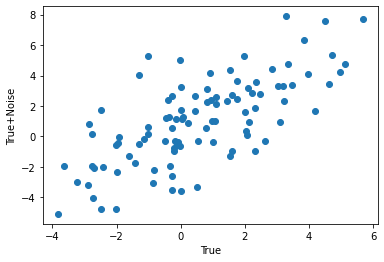

Leastsq: [1.82942771 2.72437115 1.44191936]
Leastsq MSE: 3.9749480607436265
t2: 27.08620571720818
t3: 21.89357102496044
t4: 18.306428500255137
t5: 15.285736813534385
t6: 13.144957399511966
t7: 11.546300699831924
t8: 9.962414896808674
t9: 7.414847821007322
t10: 5.912168882900845
t11: 5.646914951797321
t12: 5.424640274973204
t13: 5.308465020950197
t14: 5.179982892173118
t15: 5.091147289487166
t16: 4.977394646540297
t17: 4.6736331226207275
t18: 4.396453743362575
t19: 4.277805648263733
t20: 4.240134644977921
GA time: 1.1666202545166016


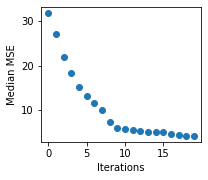

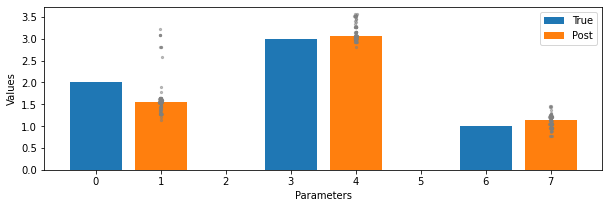

INFO:History:Start <ABCSMC(id=29, start_time=2020-09-30 10:04:36.894167, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 30.152807754701417
INFO:ABC:t: 0, eps: 30.152807754701417.
INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 19.57440376600205.
INFO:ABC:Acceptance rate: 100 / 231 = 4.3290e-01, ESS=8.9228e+01.
INFO:ABC:t: 2, eps: 12.945708903445503.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=6.8403e+01.
INFO:ABC:t: 3, eps: 9.378389777419265.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=9.0962e+01.
INFO:ABC:t: 4, eps: 7.561222207648902.
INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=9.0150e+01.
INFO:ABC:t: 5, eps: 6.456913198409616.
INFO:ABC:Acceptance rate: 100 / 197 = 5.0761e-01, ESS=7.3064e+01.
INFO:ABC:t: 6, eps: 5.867608132009396.
INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01, ESS=8.7047e+01.
INFO:ABC:t: 7, eps: 5.251036369645553.
INFO:ABC:Acceptance rate: 100 / 191 = 5.2356

SMC-ABC classical: 12.952469110488892


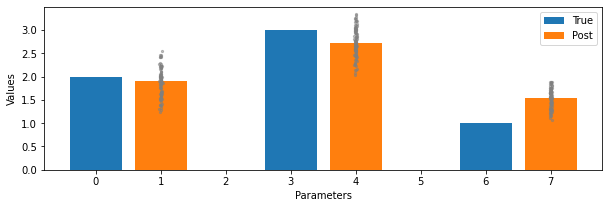

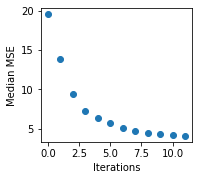

updating population
t1: epsilon= 32.174847135700375
Updating prior
updating population
t2: epsilon= 18.426806913381213
Updating prior
updating population
t3: epsilon= 11.607918961978402
Updating prior
updating population
t4: epsilon= 7.834384556486592
Updating prior
updating population
t5: epsilon= 5.78725429871594
Updating prior
updating population
t6: epsilon= 5.015824472289826
Updating prior
updating population
t7: epsilon= 4.383431920643265
Updating prior
updating population
t8: epsilon= 4.229116163836334
Updating prior
SMC-ABC this work: 11.281185388565063


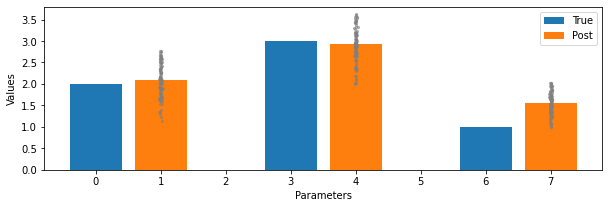

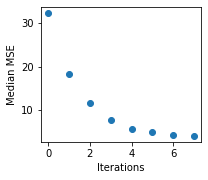

In [6]:
true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1 = case()

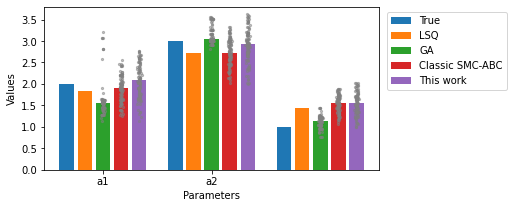

In [7]:
compare_params_bar(true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1)

/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


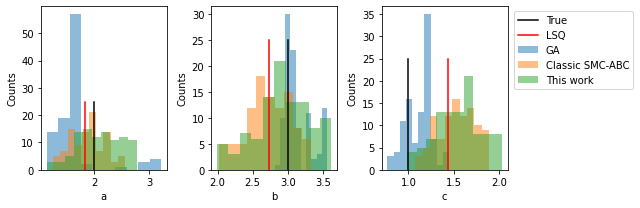

In [8]:
compare_params_hist(true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1,'../figures/{0}_p_dist.pdf'.format(tag))